В данном блокноте мы рассмотрим несколько вариантов отслеживания объектов на видео.

Начнем с метода Optical Flow, который, по своей сути, сводится к трекингу всех пикселей на видео. Обычно этот метод визуализируют либо непосредственно векторами, либо цветом (каждый цвет кодирует определенный вектор).

Для начала загрузим необходимые библиотеки.


In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


Теперь напишем функцию, которая будет полезна для визуализации векторами. На основании полученных данных, она на исходном кадре будет рисовать вектор (наше видео будет обрабатываться покадрово).

In [2]:
def draw_flow(img, flow):
  step=30
  h, w = img.shape[:2]
  y, x = np.mgrid[step / 2:h:step, step / 2:w:step].reshape(2, -1).astype(int)
  fx, fy = flow[y, x].T
  lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
  lines = np.int32(lines + 0.5)
  image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  for (x1, y1), (x2, y2) in lines:
    cv2.arrowedLine(image, (x1, y1), (x2, y2), (255, 0, 0), 1, cv2.LINE_AA, 0, 0.3)
  return image

Считаем наш видео файл средствами библиотеки OpenCV. Данный метод предполагает работу с черно-белыми изображениями. Сразу же создадим копию первого кадра нужного размера и закрасим её черным (именно на ней мы увидим визуализацию цветом).

In [8]:
cap = cv2.VideoCapture("/content/Airport__f.mp4")
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

К сожалению, данная среда разработки не позволяет демонстрировать видео-файлы. Поэтому мы будем покадрово записывать наши результаты в файл, который в дальнейшем можно посмотреть на любом плеере.

In [9]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
videoHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output_OpticalFlow.avi',fourcc, 20.0,(videoWidth,videoHeight))

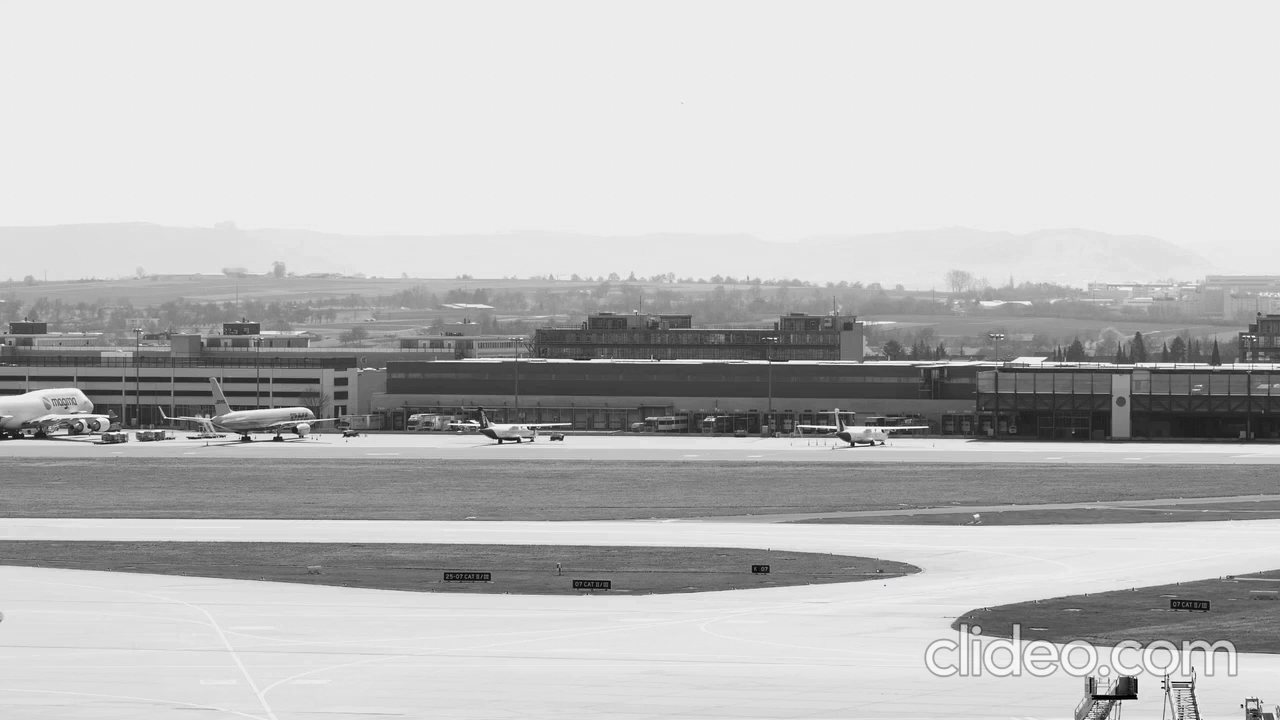

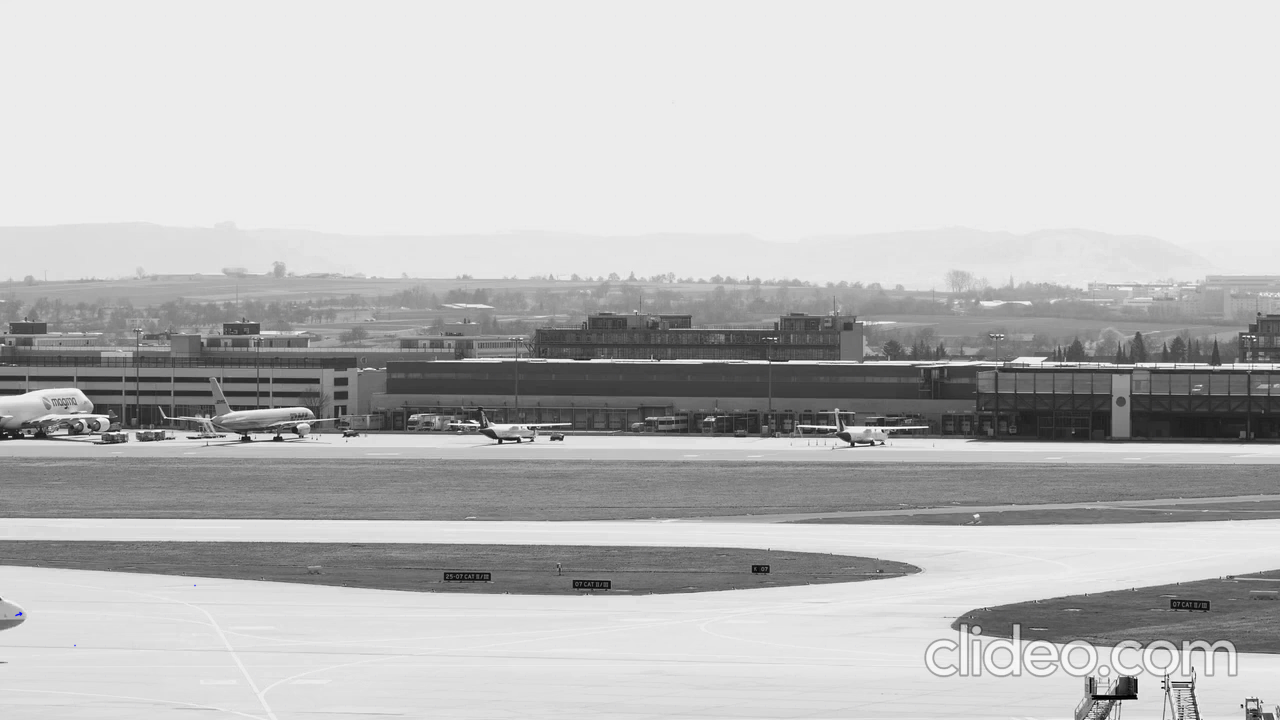

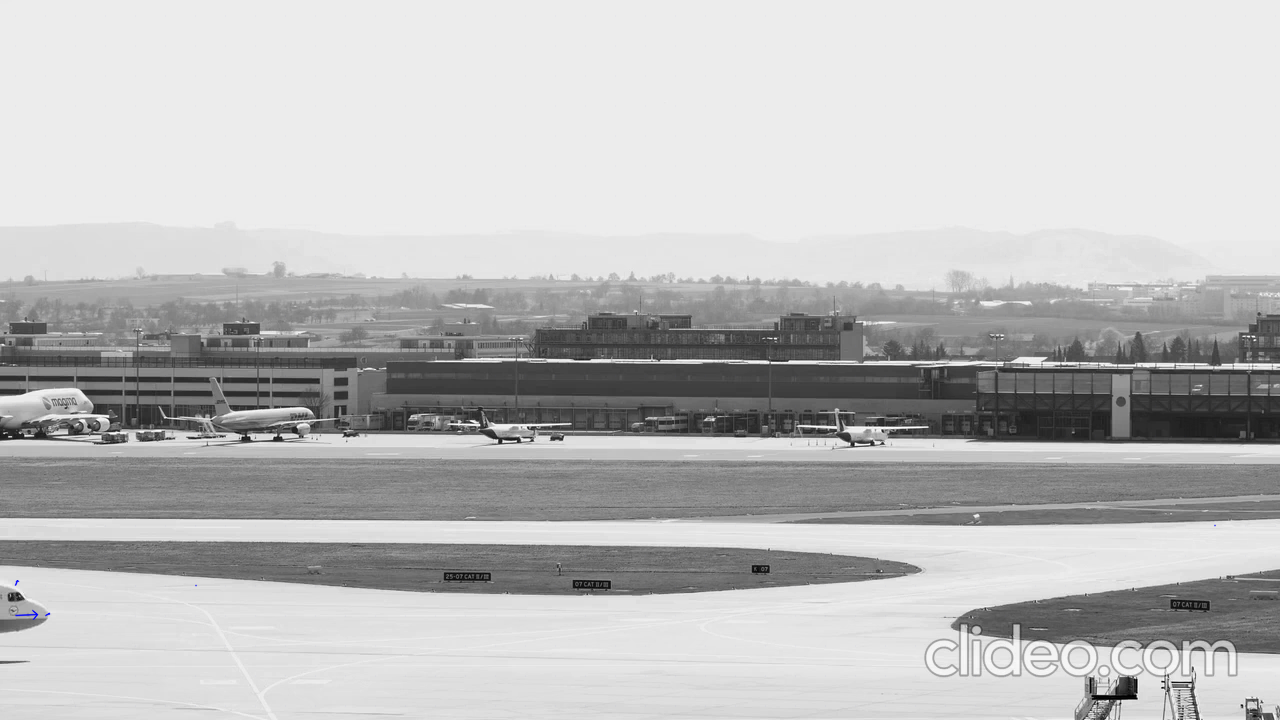

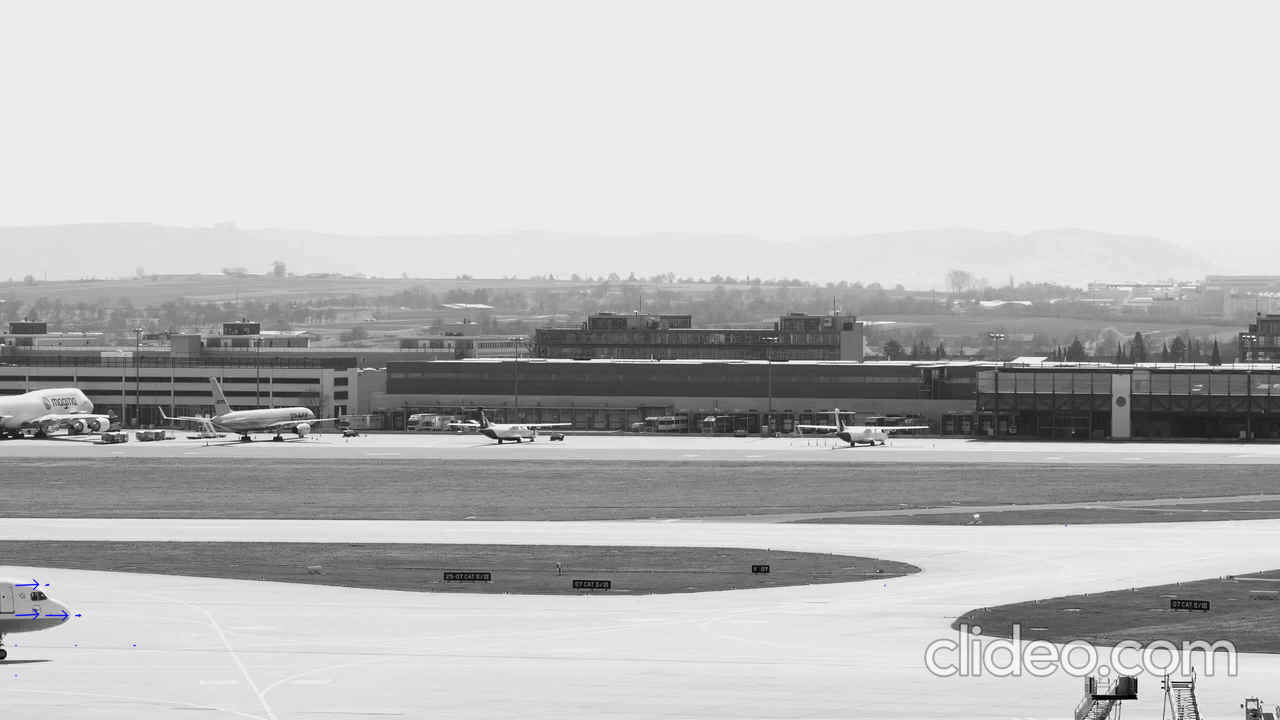

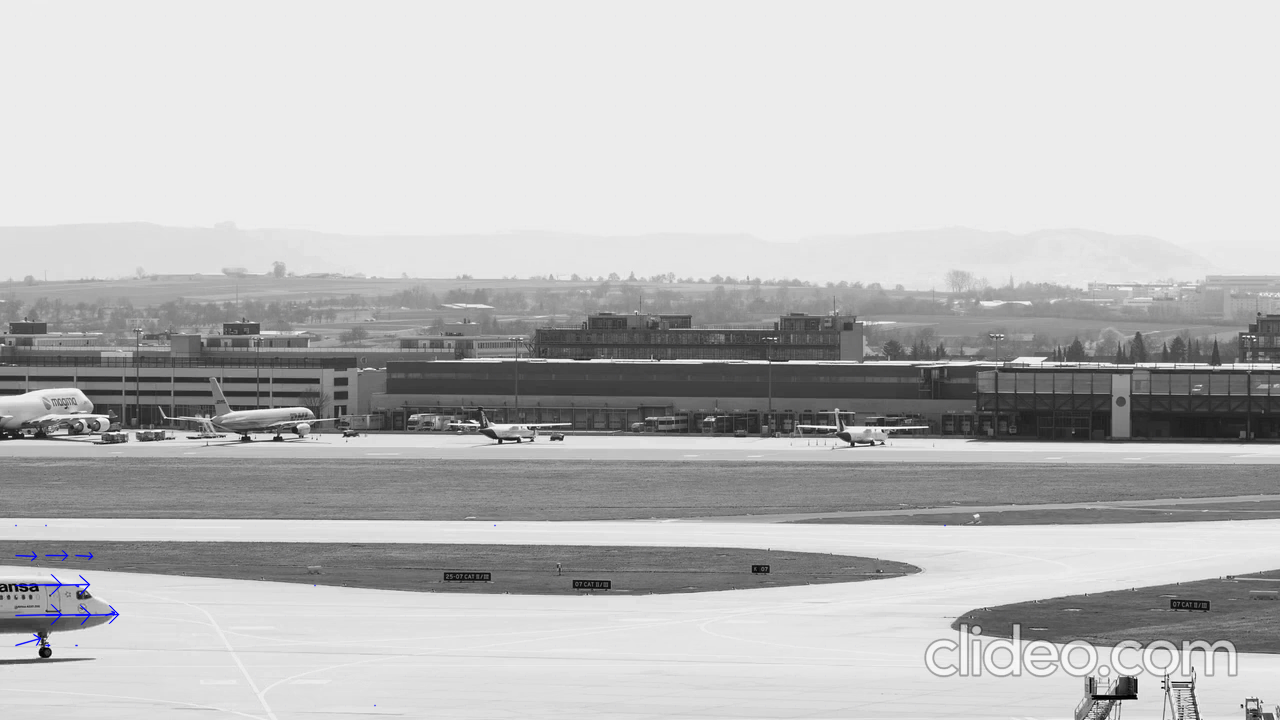

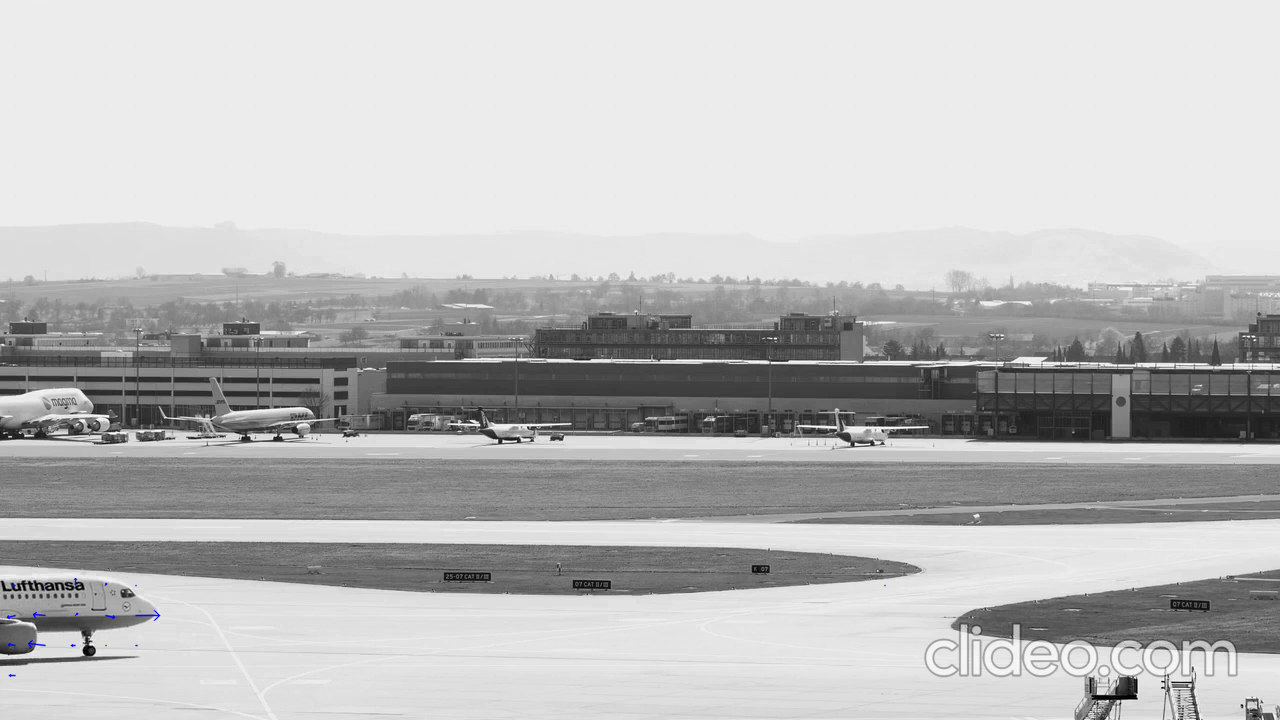

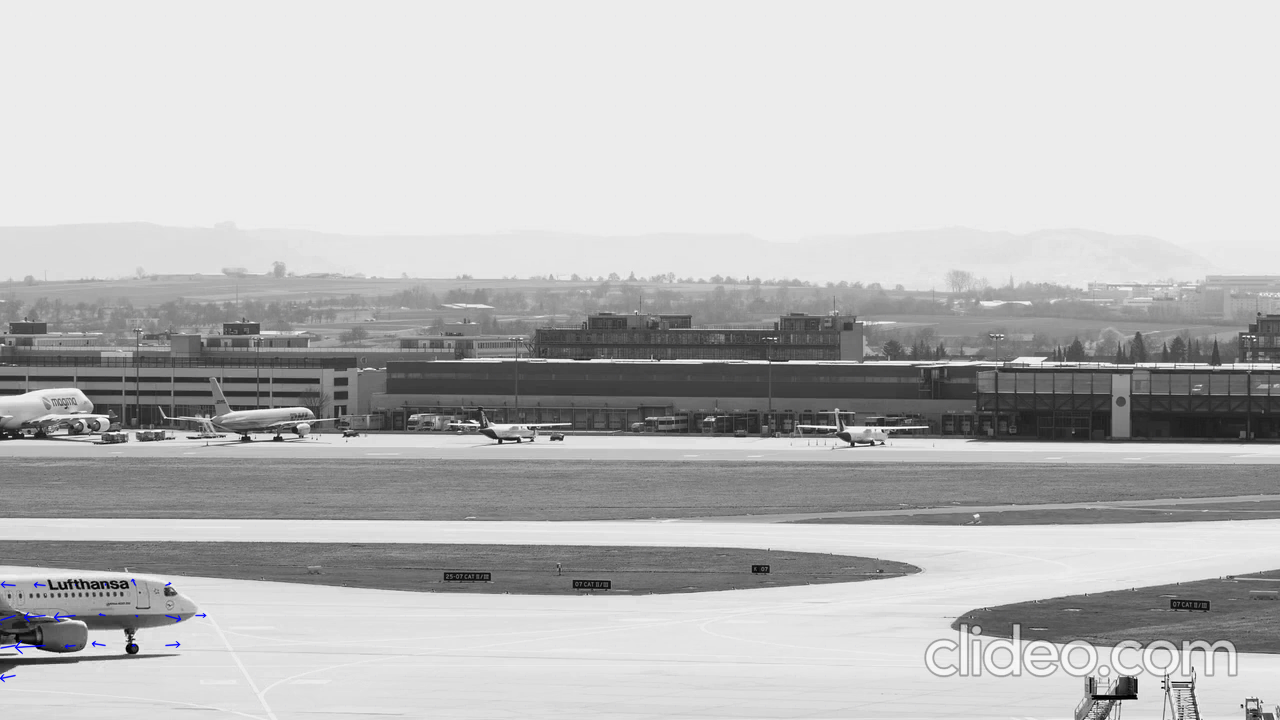

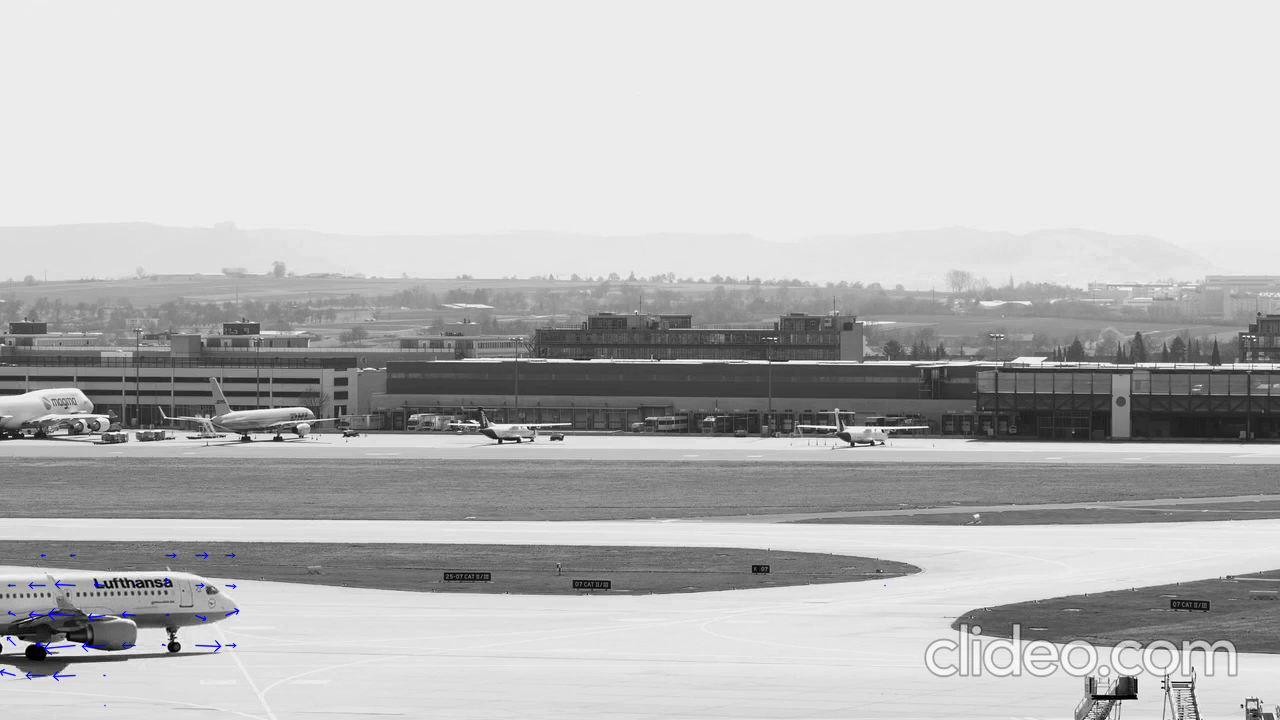

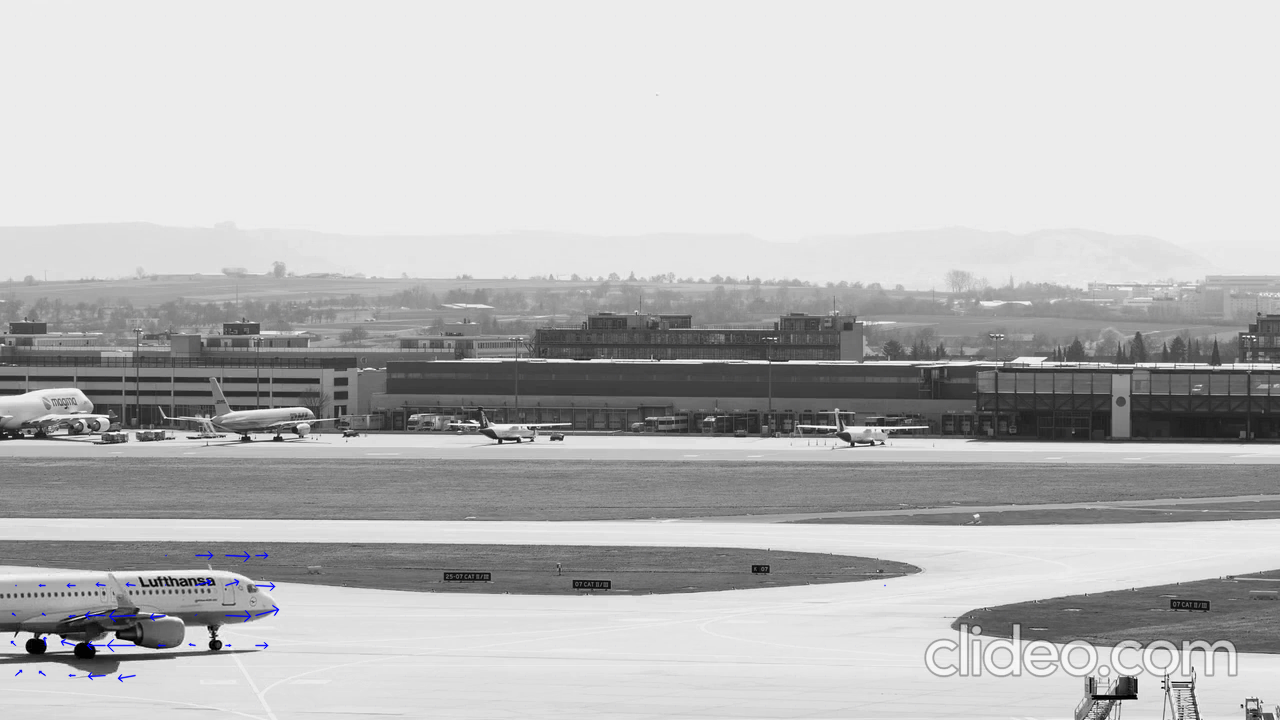

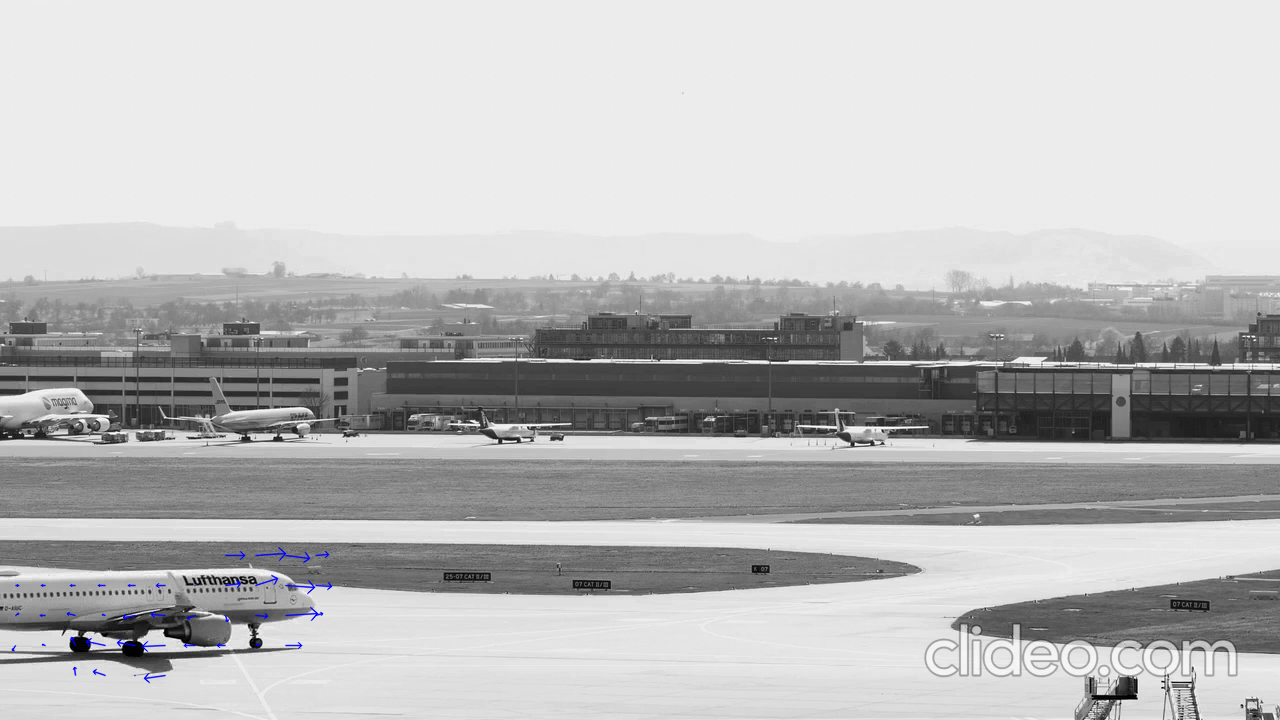

KeyboardInterrupt: ignored

In [10]:
kk = 0
while(cap.isOpened()):
    # Считываем видео кадр за кадром
    ret, frame2 = cap.read() 
    if ret:
      next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
      flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
      # Получаем векторы и заполняем значениями нашу копию для визуализации цветом
      mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
      hsv[...,0] = ang*180/np.pi/2
      hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
      bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
      # Выведем первые 10 кадров на экран с нарисованными векторами
      if kk < 10:
        cv2_imshow(draw_flow(next, flow))
      # Записываем кадр в результирующий файл
      out.write(bgr)
      # Переобозначаем кадры - предыдущий становится текущим
      prvs = next
      kk += 1
    else:
      break
cap.release()
out.release()
cv2.destroyAllWindows()

Теперь посмотрим как работает на нашем видео другой детектор — SORT (Simple Online and Realtime Tracking). Для сопоставления траекторий и обнаружения новых объектов, мы будем использовать алгоритм YOLO (You Only Look Once) - венгерский алгоритм, использующий фильтр Калмана для предсказания и корректировки сегментов.

Для начала доустановим необходимые библиотеки.

In [11]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110473 sha256=4abe27f88f35b7566a88950f565175fd9f021dcf03018b92f4b11cd33d9017ae
  Stored in directory: /root/.cache/pip/wheels/53/e6/de/a09ea01e923aaf88b9f8c7c44329e857b2c1a31901167e55e6
Successfully built filterpy


In [12]:
import random

try:
  from numba import jit
except:
  def jit(func):
    return func

np.random.seed(0)

from filterpy.kalman import KalmanFilter

Воспользуемся открытой для использования уже натренированной моделью Darknet (конфигурация, веса) на СОСО данных. Оставляем все комментарии в исходном виде.

In [13]:
def linear_assignment(cost_matrix):
  try:
    import lap
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    return np.array([[y[i],i] for i in x if i >= 0]) #
  except ImportError:
    from scipy.optimize import linear_sum_assignment
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))


@jit
def iou(bb_test, bb_gt):
  """
  Computes IUO between two bboxes in the form [x1,y1,x2,y2]
  """
  xx1 = np.maximum(bb_test[0], bb_gt[0])
  yy1 = np.maximum(bb_test[1], bb_gt[1])
  xx2 = np.minimum(bb_test[2], bb_gt[2])
  yy2 = np.minimum(bb_test[3], bb_gt[3])
  w = np.maximum(0., xx2 - xx1)
  h = np.maximum(0., yy2 - yy1)
  wh = w * h
  o = wh / ((bb_test[2] - bb_test[0]) * (bb_test[3] - bb_test[1])
    + (bb_gt[2] - bb_gt[0]) * (bb_gt[3] - bb_gt[1]) - wh)
  return(o)


def convert_bbox_to_z(bbox):
  """
  Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio
  """
  w = bbox[2] - bbox[0]
  h = bbox[3] - bbox[1]
  x = bbox[0] + w/2.
  y = bbox[1] + h/2.
  s = w * h    #scale is just area
  r = w / float(h)
  return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x,score=None):
  """
  Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
  """
  w = np.sqrt(x[2] * x[3])
  h = x[2] / w
  if(score==None):
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
  else:
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))


class KalmanBoxTracker(object):
  """
  This class represents the internal state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4) 
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.time_since_update = 0
    self.id = KalmanBoxTracker.count
    KalmanBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)


def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
  """
  Assigns detections to tracked object (both represented as bounding boxes)
  Returns 3 lists of matches, unmatched_detections and unmatched_trackers
  """
  if(len(trackers)==0):
    return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
  iou_matrix = np.zeros((len(detections),len(trackers)),dtype=np.float32)

  for d,det in enumerate(detections):
    for t,trk in enumerate(trackers):
      iou_matrix[d,t] = iou(det,trk)

  if min(iou_matrix.shape) > 0:
    a = (iou_matrix > iou_threshold).astype(np.int32)
    if a.sum(1).max() == 1 and a.sum(0).max() == 1:
        matched_indices = np.stack(np.where(a), axis=1)
    else:
      matched_indices = linear_assignment(-iou_matrix)
  else:
    matched_indices = np.empty(shape=(0,2))

  unmatched_detections = []
  for d, det in enumerate(detections):
    if(d not in matched_indices[:,0]):
      unmatched_detections.append(d)
  unmatched_trackers = []
  for t, trk in enumerate(trackers):
    if(t not in matched_indices[:,1]):
      unmatched_trackers.append(t)

  #filter out matched with low IOU
  matches = []
  for m in matched_indices:
    if(iou_matrix[m[0], m[1]]<iou_threshold):
      unmatched_detections.append(m[0])
      unmatched_trackers.append(m[1])
    else:
      matches.append(m.reshape(1,2))
  if(len(matches)==0):
    matches = np.empty((0,2),dtype=int)
  else:
    matches = np.concatenate(matches,axis=0)

  return matches, np.array(unmatched_detections), np.array(unmatched_trackers)


class Sort(object):
  def __init__(self, max_age=1, min_hits=3):
    """
    Sets key parameters for SORT
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.trackers = []
    self.frame_count = 0

  def update(self, dets=np.empty((0, 5))):
    """
    Params:
      dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
    Returns the a similar array, where the last column is the object ID.
    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    self.frame_count += 1
    # get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers), 5))
    to_del = []
    ret = []
    for t, trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if np.any(np.isnan(pos)):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks)

    # update matched trackers with assigned detections
    for m in matched:
      self.trackers[m[1]].update(dets[m[0], :])

    # create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:])
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
          ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1)) # +1 as MOT benchmark requires positive
        i -= 1
        # remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.concatenate(ret)
    return np.empty((0,5))

Необходимые веса yolov3.weights можно скачать с сайта https://pjreddie.com/darknet/yolo/.

In [14]:
import os
from os.path import exists, join, basename, splitext
if not exists('yolov3.weights'):
  !wget -q  https://pjreddie.com/media/files/yolov3.weights  

А теперь перейдем непосредственно к детектированию нашего видео. Опять-таки из-за проблем с представлением видео-файлов, мы будем писать результат в отдельный файл.

In [15]:
def load_class_names(namesfile):
    class_names = []
    with open(namesfile, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.rstrip()
        class_names.append(line)
    return class_names

In [92]:
scores

array([9.8798871e-01, 9.8790509e-01, 9.5173165e-02, 2.8064605e-02,
       2.4687720e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

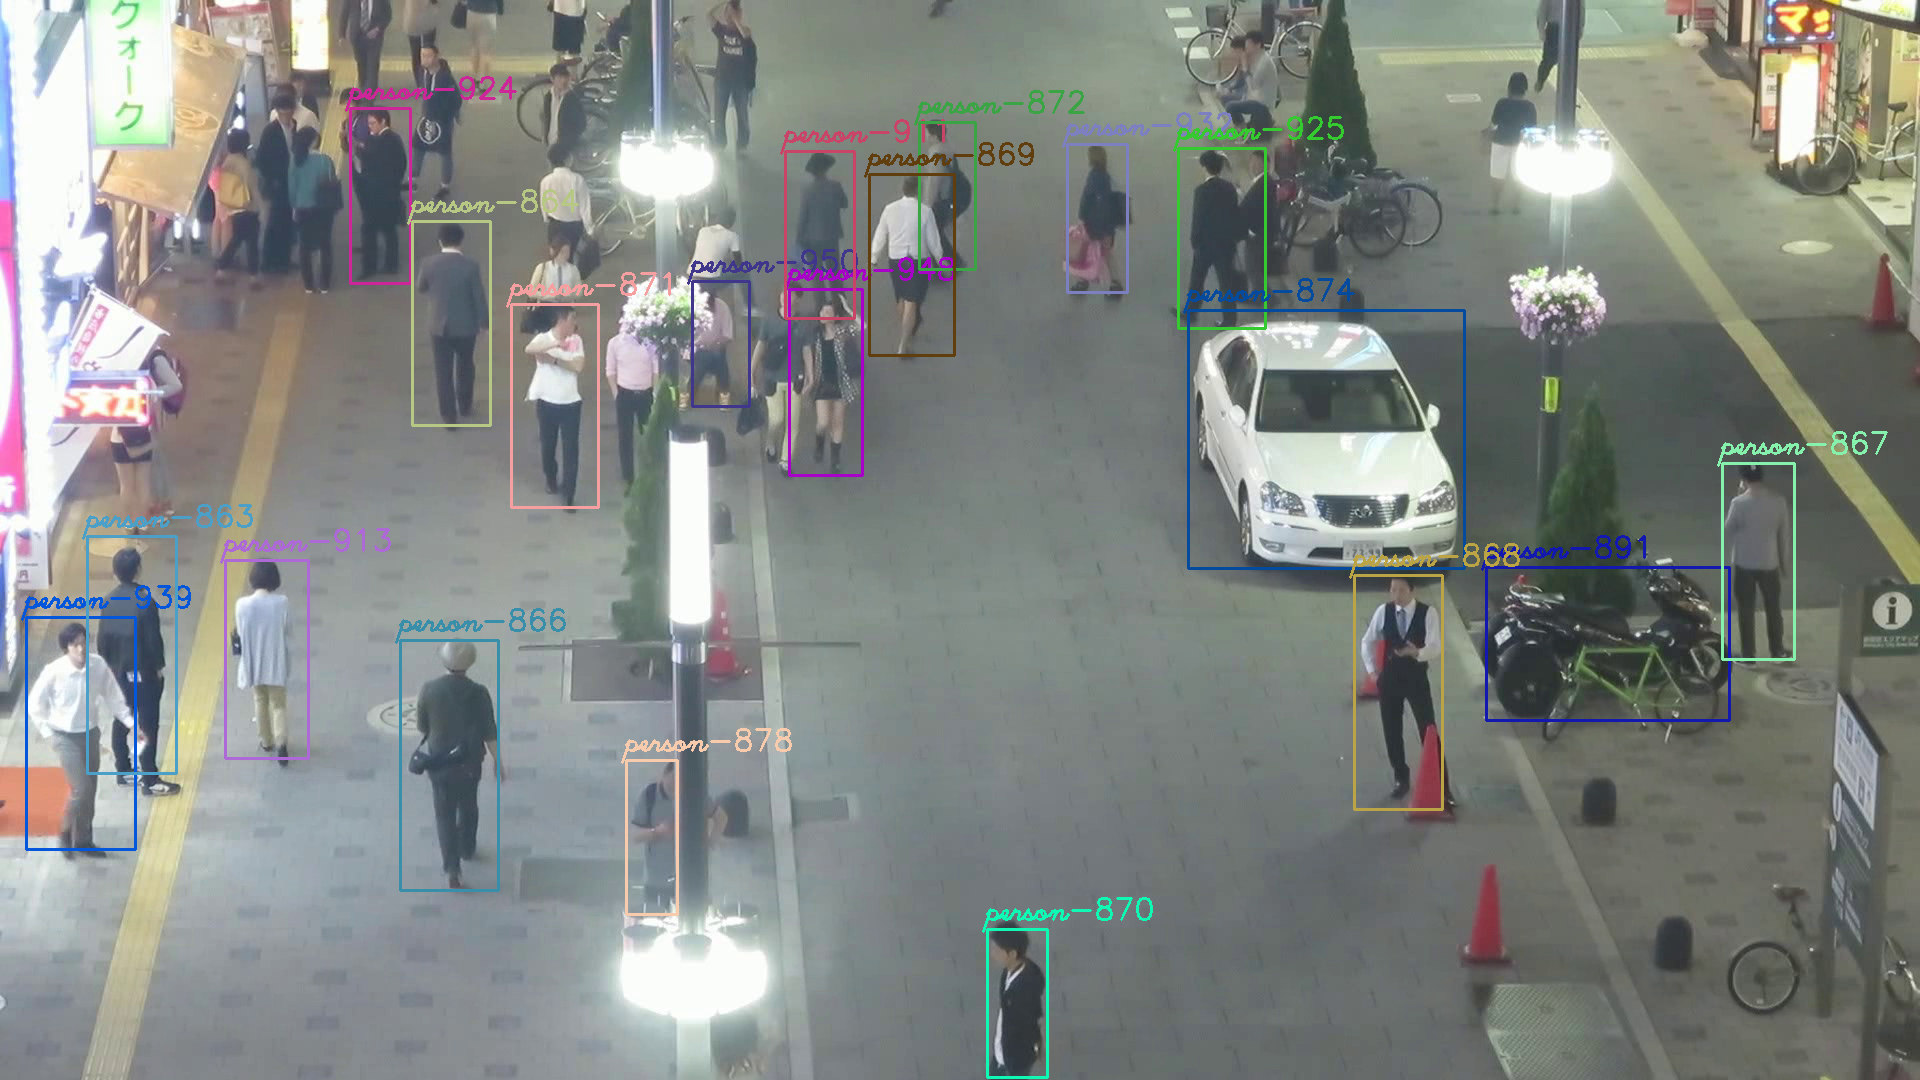

In [129]:
# Загружаем сеть
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
# Инициализируем трекер
mot_tracker = Sort()
# Используем YOLO
namesfile = 'coco.names'
class_names = load_class_names(namesfile)
# Указываем необходимый видео-файл
cap = cv2.VideoCapture("task.mp4")
# Указываем кодеки для результирующего видео
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
videoHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Определяем результирующее видео
out = cv2.VideoWriter('output_SORT.avi',fourcc, 20.0,(videoWidth,videoHeight))
# Генерируем будующим прямоугольникам разные цвета
color_list = []
for j in range(1000):
  color_list.append(((int)(random.randrange(255)),(int)(random.randrange(255)),(int)(random.randrange(255))))

kk = 0 
ret = True

n_images = 0
max_n_objects = 0
max_n_classes = 0

while ret:
  ret, img = cap.read()
  n_images += 1
  if ret:
  # Запустим сеть по кадру
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    h,w,_ = img.shape
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    # Разберём все выходы
    boxes=[]
    confidences=[]
    classIDs=[]
    for output in layerOutputs:
      for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        # print(confidence)
        if confidence > 0.5:
          box = detection[0:4] * np.array([w, h, w, h])
          (centerX, centerY, width, height) = box.astype("int")
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)
  else: 
    break
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
  result_img = np.copy(img)
  dets = []
  count_detection=0
  boxes_, confidences_, classIDs_ = [], [], []
  for j in range(len(idxs)):
    name = class_names[classIDs[idxs[j]]]
    # if name == 'aeroplane':
    count_detection+=1
    boxes_.append(boxes[idxs[j]])
    confidences_.append(confidences[idxs[j]])
    classIDs_.append(classIDs[idxs[j]])
  max_n_objects = max(max_n_objects, count_detection)
  max_n_classes = max(max_n_classes, len(set(classIDs)))

  if count_detection>0:
    detects = np.zeros((count_detection,5))
    count=0
    # Формат, необходимый для трекера
    for j in range(len(idxs)):
      b = boxes[idxs[j]]
      name = class_names[classIDs[idxs[j]]]
      # if name == 'aeroplane': # указываем необходимую метку для объектов
      x1 = int(b[0])
      y1 = int(b[1])
      x2 = int((b[0] + b[2]))
      y2 = int((b[1] + b[3]))
      box = np.array([x1,y1,x2,y2,confidences[idxs[j]]])
      detects[count,:] = box[:]
      count+=1
    
    # Парсим данные трекера
    if len(detects)!=0:
      trackers = mot_tracker.update(detects)
      for d in trackers:
        result_img = cv2.rectangle(result_img, ((int)(d[0]), (int)(d[1])), ((int)(d[2]), (int)(d[3])), color_list[(int)(d[4])], 2)
        result_img = cv2.putText(result_img, name + "-" + str(int(d[4])), ((int)(d[0]), (int)(d[1]) - 10), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, color_list[(int)(d[4])], 2)
  
  # if kk % 20 == 0 and kk < 100:
  #   cv2_imshow(result_img) # выводим только ограниченное количество кадров 
  if kk == 89:
    img_info = {
        "boxes": boxes_,
        "confidences": confidences_,
        "classIDs": classIDs_,
    }
    cv2_imshow(result_img) # выводим только ограниченное количество кадров 
  out.write(result_img) # пишем кадр в результирующее видео
  kk += 1
cap.release()
out.release()
cv2.destroyAllWindows()

In [130]:
print(f"Количество кадров: {kk}")
print(f"Максимальное количество распознанных объектов: {max_n_objects}")
print(f"Максимальное количество распознанных классов: {max_n_classes}")

Количество кадров: 100
Максимальное количество распознанных объектов: 27
Максимальное количество распознанных классов: 4


In [131]:
max_idx = np.argmax(img_info['confidences'])

In [132]:
img_info['confidences'][max_idx]

0.9918854832649231

In [137]:
class_names[img_info['classIDs'][max_idx]]

'person'

In [141]:
x1, y1, h1, h2 = img_info['boxes'][max_idx]

In [139]:
img_info['boxes'][max_idx]

[401, 641, 97, 249]

In [142]:
x1, y1, h1, h2

(401, 641, 97, 249)

In [125]:
kk

100